# Telechargements

> Disclaimer : ce dode d'implémentation de graphSage plus parametrisé et automatisé à l'aide de Pytorch Lightning a été adapté à partir du code d'example pour cet algoritme disponible dans le répertoire github oficiel de dgl 







In [ ]:
#Installation de la librairie DGL pour la manipulation de graphes 
! pip install dgl -f https://data.dgl.ai/wheels/repo.html 
#Installation de la librairie qui permet d'ouvrir des graphes stockés sous format pickle 
! pip3 install pickle5
#Installation de la librairie qui contient quelques graphes de benchmark sur lesquels tester l'architecture 
! pip install ogb

Looking in links: https://data.dgl.ai/wheels/repo.html
     |████████████████████████████████| 6.1 MB 12.2 MB/s 
     |████████████████████████████████| 256 kB 13.7 MB/s 
     |████████████████████████████████| 78 kB 4.5 MB/s 
  Created wheel for littleutils: filename=littleutils-0.2.2-py3-none-any.whl size=7048 sha256=f987a42906394257b5605d8f7e55268363dde3278dd78323f268ce54b755e50d
  Stored in directory: /root/.cache/pip/wheels/d6/64/cd/32819b511a488e4993f2fab909a95330289c3f4e0f6ef4676d
Successfully built littleutils


In [ ]:
#Pour la définition de metrics de performance du reseau custom 
! pip install torchmetrics
#Définition compacte de toutes les étapes du workflow machine learning avec pytorch
! pip install pytorch_lightning

     |████████████████████████████████| 397 kB 13.1 MB/s 
     |████████████████████████████████| 527 kB 12.2 MB/s 
     |████████████████████████████████| 952 kB 39.2 MB/s 
     |████████████████████████████████| 134 kB 39.8 MB/s 
     |████████████████████████████████| 596 kB 43.3 MB/s 
     |████████████████████████████████| 829 kB 12.2 MB/s 
     |████████████████████████████████| 1.1 MB 10.7 MB/s 
     |████████████████████████████████| 144 kB 46.4 MB/s 
     |████████████████████████████████| 94 kB 1.6 MB/s 
     |████████████████████████████████| 271 kB 37.9 MB/s 
  Created wheel for future: filename=future-0.18.2-py3-none-any.whl size=491070 sha256=44ef381836dd7967e5de1be3573cdcc370a563c487ec222539499cc439c06160
  Stored in directory: /root/.cache/pip/wheels/56/b0/fe/4410d17b32f1f0c3cf54cdfb2bc04d7b4b8f4ae377e2229ba0
Successfully built future
  Attempting uninstall: setuptools
    Found existing installation: setuptools 57.4.0
    Uninstalling setuptools-57.4.0:
      Successfu

In [ ]:
%matplotlib inline

# Imports

In [ ]:
#Imports generaux 
import os 
import time
import random
import tqdm
import glob

#Gestion de vectecteurs et matrices 
import numpy as np

#gestion des datasets 
import pandas as pd

#Gestion des graphes 
import networkx as nx
import pickle5 as pickle
import dgl
import dgl.nn as dglnn
import dgl.function as fn

#Affichage de valeurs 
import matplotlib.pyplot as plt
import seaborn as sns

#Définitions mathématiques 
import torch as th
import torch.nn as nn
import torch.nn.functional as F
#optimisateurs de pytorch
import torch.optim as optim

#Mesures de la qualité des prédictions 
import sklearn.utils as sk
import sklearn.linear_model as lm
import sklearn.metrics as skm
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

#Mesure custom de la performance du modèle
from torchmetrics import Accuracy

#Implémentation compacte du workflow machine learning 
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint, Callback
from pytorch_lightning import LightningDataModule, LightningModule, Trainer

DGL backend not selected or invalid.  Assuming PyTorch for now.


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


## Import du répositoire avec nos données propres


In [ ]:
os.makedirs("groupeRepo",exist_ok=True)
%cd groupeRepo
! if cd projet_long_GCN_internet; then git pull; else git clone https://github.com/Viperine2022/projet_long_GCN_internet; fi
%cd ..
! ls

/content/groupeRepo
/bin/bash: line 0: cd: projet_long_GCN_internet: No such file or directory
Cloning into 'projet_long_GCN_internet'...
remote: Enumerating objects: 573, done.
remote: Counting objects: 100% (573/573), done.
remote: Compressing objects: 100% (293/293), done.
remote: Total 573 (delta 348), reused 493 (delta 271), pack-reused 0
Receiving objects: 100% (573/573), 88.31 MiB | 10.04 MiB/s, done.
Resolving deltas: 100% (348/348), done.
Checking out files: 100% (134/134), done.
/content
groupeRepo  sample_data


#Chargement des données ogb

Il s'agit une librairie comprenant des graphes sous format dgl donc directement exploitable par les fonctions qui suivent

En particulier nous utiliserons surtout le graphe ogbn-arxiv qui est le plus proche en taille aux graphes CAIDA qu'on manipule comportant un dataset de citations avec 169,343 noeuds et 1,166,243	arêtes. D'ailleurs dans le paper définisant GraphSAGE l'algorithme est testé sur un dataset de nature similaire ainsi on devrait observer des bonnes performances sur ce type de dataset 

In [ ]:

def load_ogb(name, root='dataset'):
    from ogb.nodeproppred import DglNodePropPredDataset

    print('load', name)
    data = DglNodePropPredDataset(name=name, root=root)
    print('finish loading', name)
    splitted_idx = data.get_idx_split()
    graph, labels = data[0]
    labels = labels[:, 0]

    graph.ndata['features'] = graph.ndata.pop('feat')
    graph.ndata['labels'] = labels
    in_feats = graph.ndata['features'].shape[1]
    num_labels = len(th.unique(labels[th.logical_not(th.isnan(labels))]))

    # Find the node IDs in the training, validation, and test set.
    train_nid, val_nid, test_nid = splitted_idx['train'], splitted_idx['valid'], splitted_idx['test']
    train_mask = th.zeros((graph.number_of_nodes(),), dtype=th.bool)
    train_mask[train_nid] = True
    val_mask = th.zeros((graph.number_of_nodes(),), dtype=th.bool)
    val_mask[val_nid] = True
    test_mask = th.zeros((graph.number_of_nodes(),), dtype=th.bool)
    test_mask[test_nid] = True
    graph.ndata['train_mask'] = train_mask
    graph.ndata['val_mask'] = val_mask
    graph.ndata['test_mask'] = test_mask
    print('finish constructing', name)
    return graph, num_labels, train_nid, val_nid, test_nid

## Affichage des données CAIDA
Cette opération est aussi réalisée par la fonction *load_caida* qui suit mais ce bout de code permet de confirmer visuellement que les données ont le format correcte 

In [ ]:
dataset_path = '/content/groupeRepo/projet_long_GCN_internet/IMPLANTATION/CAIDA/data_GCN/dataset_v2_20210301.csv'
dataset = pd.read_csv(dataset_path)
print(dataset.keys())
print(dataset['label'].unique())
print(dataset['label'].map({'Content':0,'Transit/Access':1,'Enterprise':2}))

Index(['ASN', 'source_label', 'label', 'page_rank_not_directed',
       'page_rank_directed', 'page_rank_directed_inverse', 'degree_centrality',
       'degree_normalized', 'ratio_peering', 'ratio_customer',
       'ratio_provider'],
      dtype='object')
['Transit/Access' 'Enterprise' 'Content']
0        1
1        1
2        1
3        1
4        2
        ..
71429    1
71430    1
71431    1
71432    1
71433    2
Name: label, Length: 71434, dtype: int64


In [ ]:
#Code repris de l'autre fichier ipynb appliquant des methodes GCN
def load_caida():
  
# Lecture de la table 'node_features' au format csv
  dataset_path = '/content/groupeRepo/projet_long_GCN_internet/IMPLANTATION/CAIDA/data_GCN/dataset_v2_20210301.csv'
  dataset = pd.read_csv(dataset_path)
  nb_nodes = len(dataset.index)

  #Définition d'une permutation des noeuds pour avoir une répartition en ensembles de train, validation et test 
  perm = np.random.permutation(nb_nodes)
  A_train = perm[:int(0.8*nb_nodes)]
  A_val = perm[int(0.8*nb_nodes): int(0.9*nb_nodes)]
  A_test = perm[int(0.9*nb_nodes):] 

  #On définit des listes d'identifiants pour chaque ensemble 
  train_nid, val_nid, test_nid = A_train, A_val, A_test

  #On s'en sert des identifiants pour définir des masques booléens qui appliqués au graphe retourneront que les noeuds de chaque sous-ensemble
  train_mask_int=np.zeros((nb_nodes))
  val_mask_int=np.zeros((nb_nodes))
  test_mask_int=np.zeros((nb_nodes))
  train_mask_int=np.zeros((nb_nodes))
  val_mask_int=np.zeros((nb_nodes))
  test_mask_int=np.zeros((nb_nodes))

  train_mask_int[A_train] = 1
  val_mask_int[A_val] = 1
  test_mask_int[A_test] = 1

  train_mask = train_mask_int > 0.5 
  val_mask = val_mask_int > 0.5 
  test_mask = test_mask_int > 0.5 

  #On reconvertit le masque sous la forme de dictionaires sur chaque noeud, ainsi en consultant que le noeud on connaîtra sa 
  #nature c'est à dire si c'est un node training, un node validation ou un node test 
  dict_train_mask = dict(zip(np.arange(nb_nodes), train_mask))
  isinstance(dict_train_mask, dict)

  dict_val_mask = dict(zip(np.arange(nb_nodes), val_mask))
  isinstance(dict_val_mask, dict)

  dict_test_mask = dict(zip(np.arange(nb_nodes), test_mask))
  isinstance(dict_test_mask, dict)

  #On définit ici les attributs qu'on va utiliser lors de l'entraînement 
  listeAttributs = ['page_rank_not_directed','page_rank_directed',
                    'page_rank_directed_inverse', 'degree_centrality',
                    'degree_normalized', 'ratio_peering', 'ratio_customer',
                    'ratio_provider']

  #On garde que les attributs dans une matrice
  a = dataset[listeAttributs]
  #On change les label en entiers et on les stocke dans un vecteur
  l = dataset['label'].map({'Content':0,'Transit/Access':1,'Enterprise':2})
  #On transforme le type de la matrice car si le type n'est pas uniforme on ne peut pas l'assigner au graphe
  a_np = a.to_numpy().astype(float)
  #Même cas pour le vecteur des labels
  l_np = l.to_numpy().astype(int)

  #Affichage du type réel pris par les attributs parce qu'il y a souvent des problèmes de typage float -- double
  print("Le dataframe des attributs chargés admet le type: ",type(a))

  # Lecture du graphe nx puis transformation en graphe dgl : G_dgl avec edges features float
  path_to_protocol5 = '/content/groupeRepo/projet_long_GCN_internet/IMPLANTATION/CAIDA/data_GCN/graph_float_20210301.pickle'
  with open(path_to_protocol5, "rb") as fh:
    G_float = pickle.load(fh)

  #Définition des masques dans le résseau network x 
  nx.set_node_attributes(G_float, dict_train_mask, "train_mask")
  nx.set_node_attributes(G_float, dict_test_mask, "test_mask")
  nx.set_node_attributes(G_float, dict_val_mask, "val_mask")

  #import des masques et labels des nodes 
  G_dgl_float = dgl.from_networkx(G_float, node_attrs=['label', 'train_mask', 'val_mask', 'test_mask'])

  #On ajoute les attributs comme données de noeud sous le nom clé "features" 
  G_dgl_float.ndata["features"] = th.tensor(a_np).float()

  #Certains algorithmes utilisent les attributs de classe srcdata et dstdata pour définir respectivement les attributs et les labels 
  #Donc on ajoute les données avec ce format aussi au cas où 
  G_dgl_float.srcdata['features'] = th.tensor(a_np).float()
  G_dgl_float.dstdata['labels'] = th.tensor(l_np)

  #Assignation du graphe qu'on va retourner 
  graph = G_dgl_float

  #À caida on aura toujours des données à 3 classes différentes 
  num_labels = 3

  return graph, num_labels, train_nid, val_nid, test_nid

In [ ]:
#Ici on commente ou décomente la ligne pertinente en fonction du dataset qu'on veut utiliser
#ce n'est pas très propre mais c'est fonctionnel par rapport aux deux dataset qu'on manipule

#g,nclass,train_nid,val_nid,test_nid = load_ogb("ogbn-arxiv")
g,nclass,train_nid,val_nid,test_nid = load_caida()

#Fonction qui genere des sous-graphes en fonction des masques de train validation et test qu'on a choisi pour la methode
def inductive_split(g):
    """Split the graph into training graph, validation graph, and test graph by training
    and validation masks.  Suitable for inductive models."""
    train_g = g.subgraph(g.ndata['train_mask'])
    val_g = g.subgraph(g.ndata['train_mask'] | g.ndata['val_mask'])
    test_g = g
    return train_g, val_g, test_g

train_g,val_g,test_g = inductive_split(g)

Le dataframe des attributs chargés admet le type:  <class 'pandas.core.frame.DataFrame'>


In [ ]:
#Affichage du nombre de noeuds et arrêtes dans le graphe pour vérifier qu'il a bien été chargée et avec les bons attributs
print(g.int())
print(nclass)

Graph(num_nodes=71434, num_edges=979432,
      ndata_schemes={'label': Scheme(shape=(), dtype=torch.int64), 'train_mask': Scheme(shape=(), dtype=torch.bool), 'val_mask': Scheme(shape=(), dtype=torch.bool), 'test_mask': Scheme(shape=(), dtype=torch.bool), 'features': Scheme(shape=(8,), dtype=torch.float32), 'labels': Scheme(shape=(), dtype=torch.int64)}
      edata_schemes={})
3


# Définition du modèle graphsage 

In [ ]:
#Définition d'une sous-classe du module Neural Network pour dgl 
class SAGE(nn.Module):
    def __init__(self, in_feats, n_hidden, n_classes, n_layers, activation, dropout, aggregator):
        super().__init__()
        self.init(in_feats, n_hidden, n_classes, n_layers, activation, dropout, aggregator)

    def init(self, in_feats, n_hidden, n_classes, n_layers, activation, dropout, aggregator):
        self.n_layers = n_layers
        self.n_hidden = n_hidden
        self.n_classes = n_classes
        #On initialise les classes comme une liste vide 
        self.layers = nn.ModuleList()
        #paramètre de type string qui implémente l'aggregateur du message passing 
        self.aggregator = aggregator
        if n_layers > 1:
            #couche initiale
            self.layers.append(dglnn.SAGEConv(in_feats, n_hidden, aggregator))
            #autant de couches cachées que indiqué 
            for i in range(1, n_layers - 1):
                self.layers.append(dglnn.SAGEConv(n_hidden, n_hidden, aggregator))
            self.layers.append(dglnn.SAGEConv(n_hidden, n_classes, aggregator))
        else:
            #cas de modèle avec une seule couche 
            self.layers.append(dglnn.SAGEConv(in_feats, n_classes, aggregator))
        #définition d'une couche de dropout avec le pourcentage specifié 
        self.dropout = nn.Dropout(dropout)
        self.activation = activation

    #Cette fonction s'applique pour calculer un embedding d'un noeud en utilisant les paramètres courants du modèle
    def forward(self, blocks, x):
        #l'embeding initial c'est la valeur des attributs pour chaque noeud 
        h = x
        #On applique recursivement toutes les couches du modèle 
        for l, (layer, block) in enumerate(zip(self.layers, blocks)):
            h = layer(block, h)
            #si ce n'est pas la dernière couche du res on applique la fonction d'activation et le dropout choisi par l'utilisateur 
            if l != len(self.layers) - 1:
                h = self.activation(h)
                h = self.dropout(h)
        return h

    #Cette fonction s'applique pour mettre à jour les paramètres du modèle dans ce qui est connu comme l'apprentissage
    def inference(self, g, x, batch_size, num_workers=0):
        
        # Nous ne réalisons pas du sampling des voisinages des noeuds car cette opération répeté pour chaque
        #noeud et pour chaque couche rend l'algorithme inefficient ainsi on prend tous les noeuds
        for l, layer in enumerate(self.layers):
            #on définit la matrice de poids pour toute couche
            #si c'est une couche normale la deuxième dim du tenseur sera la taille de l'embeding sinon c'est le nb de classes
            y = th.zeros(g.num_nodes(), self.n_hidden if l != len(self.layers) - 1 else self.n_classes)
            #cette section du code réalise l'algorithme minibatch 
            sampler = dgl.dataloading.MultiLayerFullNeighborSampler(1)
            dataloader = dgl.dataloading.NodeDataLoader(
                g,
                th.arange(g.num_nodes()),
                sampler,
                batch_size=batch_size,
                shuffle=False
                )
            #Ceci est l'expression d'un batch pour des graphes où : 
            #   - output_nodes represent l'ensemble de nodes dont on veut calculer l'embedding à la dernière couche 
            #   - input_nodes represente l'ensemble de nodes dont t'as besoin pour calculer l'embeding à la dernière couche (typiquement les k-hop voisins s'il y a k couches dans le modèle)
            #   - blocks represente l'ensemble de sousgraphes qui permettent à chaque couche de calculer l'embeding des noeuds à la couche suivante. Ceci se fait pour pas avoir à charger tout le 
            #     graphe à chaque étape parce que le graphe est très grand et la mémoire ram aurait du mal à calculer dans ce cas 
            for input_nodes, output_nodes, blocks in tqdm.tqdm(dataloader):
                block = blocks[0]
                block = block.int()
                #L'embeding initial ce sont les attributs des noeuds d'entrée 
                h = x[input_nodes]
                h = layer(block, h)
                #On applique les couches consecutives
                if l != len(self.layers) - 1:
                    h = self.activation(h)
                    h = self.dropout(h)
                #dernier output sont les embedings des output nodes 
                y[output_nodes] = h

            x = y
        return y

# Définition du module lightning torch supervisé à partir de notre modèle

In [ ]:
class SAGELightning(LightningModule):
    def __init__(self,
                 in_feats,
                 n_hidden,
                 n_classes,
                 n_layers,
                 activation,
                 dropout,
                 lr,
                 aggregator):
        super().__init__()
        #En cas de tuning du modèle ceci servirait à stocker la liste de hyperparams utilisés pour définir un certain modèle conservé en checkpoint
        self.save_hyperparameters()
        #On utilise une instance du modèle utilisé avant 
        self.module = SAGE(in_feats, n_hidden, n_classes, n_layers, activation, dropout, aggregator)
        self.lr = lr
        self.train_acc = Accuracy()
        self.val_acc = Accuracy()

    #Étape d'entraînement où les valeurs des paramètres sont mises à jour 
    def training_step(self, batch, batch_idx):
        #mfg = message flow graph est équivalent aux blocks dans la définition du module SAGE
        #Ici le batch est decomposé en 3 sous-parties
        input_nodes, output_nodes, mfgs = batch
        mfgs = [mfg.int() for mfg in mfgs]
        #On prend les attributs des input nodes parce qu'ils sont nécessaires pour calculer l'embeding  
        batch_inputs = mfgs[0].srcdata['features']
        #On prend les labels des output nodes parce qu'ils sont nécessaires pour calculer la valeur de la cross-entropy à la fonction de perte
        batch_labels = mfgs[-1].dstdata['labels']
        #on calcule des predictions pour les output nodes à partir de l'état courant de notre système 
        batch_pred = self.module(mfgs, batch_inputs)
        #calcul de la ocntion de perte 
        loss = F.cross_entropy(batch_pred, batch_labels)
        self.train_acc(th.softmax(batch_pred, 1), batch_labels)
        #on log l'accuracy du training 
        self.log('train_acc', self.train_acc, prog_bar=True, on_step=True, on_epoch=False)
        return loss

    def validation_step(self, batch, batch_idx):
        input_nodes, output_nodes, mfgs = batch
        mfgs = [mfg.int() for mfg in mfgs]
        #remplacer par src et dst data si ça marche pas pour les bench 
        batch_inputs = mfgs[0].srcdata['features']
        batch_labels = mfgs[-1].dstdata['labels']
        #print(batch_inputs,batch_inputs.shape)
        batch_pred = self.module(mfgs, batch_inputs)
        #print("La nature de batch labels est: ",batch_labels,batch_labels.shape," \n et cette des predictions est ",batch_pred,batch_pred.shape)
        self.val_acc(th.softmax(batch_pred, 1), batch_labels)
        self.log('val_acc', self.val_acc, prog_bar=True, on_step=True, on_epoch=True, sync_dist=True)
    
    #configuration de l'optimisateur, on prendra ADAM ici par example 
    def configure_optimizers(self):
        optimizer = th.optim.Adam(self.parameters(), lr=self.lr)
        return optimizer

In [ ]:
#Classe qui permet la gestion automatique des batches de noeuds 
class DataModule(LightningDataModule):
    def __init__(self,nb_layers, fan_out=[10, 25], batch_size=1000):
        super().__init__()
        train_nid = th.nonzero(g.ndata['train_mask'], as_tuple=True)[0]
        val_nid = th.nonzero(g.ndata['val_mask'], as_tuple=True)[0]
        test_nid = th.nonzero(~(g.ndata['train_mask'] | g.ndata['val_mask']), as_tuple=True)[0]
        #sampler = dgl.dataloading.MultiLayerNeighborSampler([int(_) for _ in fan_out])
        sampler = dgl.dataloading.MultiLayerFullNeighborSampler(nb_layers)
        self.g = g
        self.train_nid, self.val_nid, self.test_nid = train_nid, val_nid, test_nid
        self.sampler = sampler
        self.batch_size = batch_size
        #le nombre de features correspond au nombre de colonnes dans la matrice des features stocké en ndata
        self.in_feats = g.ndata['features'].shape[1]

    #On définit des dataloaders pour l'entraînement et pour la validation
    def train_dataloader(self):
        return dgl.dataloading.NodeDataLoader(
            self.g,
            self.train_nid,
            self.sampler,
            batch_size=self.batch_size,
            shuffle=True,
            drop_last=False)

    def val_dataloader(self):
        return dgl.dataloading.NodeDataLoader(
            self.g,
            self.val_nid,
            self.sampler,
            batch_size=self.batch_size,
            shuffle=True,
            drop_last=False)

#Définition de la version non-supervisé de graphSAGE


####Fonction de perte pour non supervisé 


In [ ]:
#Fonction de perte pour le modèle non supervisé 

class CrossEntropyLoss(nn.Module):
    def forward(self, block_outputs, pos_graph, neg_graph):
        #embeding des noeuds positifs 
        with pos_graph.local_scope():
            #on calcule des scores entre un ensemble de noeuds dits positifs en appliquant le produit scalaire entre leurs embedings
            pos_graph.ndata['h'] = block_outputs
            pos_graph.apply_edges(fn.u_dot_v('h', 'h', 'score'))
            pos_score = pos_graph.edata['score']
        #embeding des noeuds negatifs 
        with neg_graph.local_scope():
            neg_graph.ndata['h'] = block_outputs
            neg_graph.apply_edges(fn.u_dot_v('h', 'h', 'score'))
            neg_score = neg_graph.edata['score']
        score = th.cat([pos_score, neg_score])
        #on considère que le problème binaire où pour les positifs ça appartient toujours et pour les négatifs ça appartient jamais à la classe prédite
        label = th.cat([th.ones_like(pos_score), th.zeros_like(neg_score)]).long()
        loss = F.binary_cross_entropy_with_logits(score, label.float())
        return loss

###Calcul de l'acuracy pour l'algorithme non-supervisé 


In [ ]:
def compute_acc(emb, labels, train_nids, val_nids, test_nids):
    """
    Compute the accuracy of prediction given the labels.
    """
    emb = emb.numpy()
    labels = labels.numpy()
    train_nids = train_nids.numpy()
    train_labels = labels[train_nids]
    val_nids = val_nids.numpy()
    val_labels = labels[val_nids]
    test_nids = test_nids.numpy()
    test_labels = labels[test_nids]
    #normalisation de l'embeding 
    emb = (emb - emb.mean(0, keepdims=True)) / emb.std(0, keepdims=True)
    #classifieur qui permet de retrouver des classes à partir des embedings retrouvés 
    #on pourrait ici choisir n'importe quelle methode de classification
    lr = lm.LogisticRegression(multi_class='multinomial', max_iter=10000)
    lr.fit(emb[train_nids], train_labels)
    #évaluation de la performance du classifieur
    pred = lr.predict(emb)
    f1_micro_eval = skm.f1_score(val_labels, pred[val_nids], average='micro')
    f1_micro_test = skm.f1_score(test_labels, pred[test_nids], average='micro')
    return f1_micro_eval, f1_micro_test

### Classification des nodes à partir de l'accuracy 

In [ ]:
class UnsupervisedClassification(Callback):
    def on_validation_epoch_start(self, trainer, pl_module):
        self.val_outputs = []

    def on_validation_batch_end(self, trainer, pl_module, outputs, batch, batch_idx, dataloader_idx):
        self.val_outputs.append(outputs)

    def on_validation_epoch_end(self, trainer, pl_module):
        node_emb = th.cat(self.val_outputs, 0)
        g = trainer.datamodule.g
        labels = g.ndata['labels']
        f1_micro, f1_macro = compute_acc(
            node_emb, labels,train_nid,
            val_nid, test_nid)
        pl_module.log('val_f1_micro', f1_micro)

###Negative sampler 

In [ ]:
class NegativeSampler(object):
    def __init__(self, g, k, neg_share=False, device=None):
        self.weights = g.in_degrees().float() ** 0.75
        self.k = k
        self.neg_share = neg_share

    def __call__(self, g, eids):
        src, _ = g.find_edges(eids)
        n = len(src)
        if self.neg_share and n % self.k == 0:
            dst = self.weights.multinomial(n, replacement=True)
            dst = dst.view(-1, 1, self.k).expand(-1, self.k, -1).flatten()
        else:
            dst = self.weights.multinomial(n*self.k, replacement=True)
        src = src.repeat_interleave(self.k)
        return src, dst

###Light unsup modèles

In [ ]:
class SAGE_Unsupervised_Lightning(LightningModule):
    def __init__(self,
                 in_feats,
                 n_hidden,
                 n_classes,
                 n_layers,
                 activation,
                 dropout,
                 lr,
                 aggregator):
        super().__init__()
        self.save_hyperparameters()
        self.module = SAGE(in_feats, n_hidden, n_classes, n_layers, activation, dropout,aggregator)
        self.lr = lr
        self.loss_fcn = CrossEntropyLoss()

    def training_step(self, batch, batch_idx):
        input_nodes, pos_graph, neg_graph, mfgs = batch
        mfgs = [mfg.int() for mfg in mfgs]
        batch_inputs = mfgs[0].srcdata['features']
        batch_labels = mfgs[-1].dstdata['labels']
        batch_pred = self.module(mfgs, batch_inputs)
        loss = self.loss_fcn(batch_pred, pos_graph, neg_graph)
        self.log('train_loss', loss, prog_bar=True, on_step=False, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        input_nodes, output_nodes, mfgs = batch
        mfgs = [mfg.int() for mfg in mfgs]
        batch_inputs = mfgs[0].srcdata['features']
        batch_labels = mfgs[-1].dstdata['labels']
        batch_pred = self.module(mfgs, batch_inputs)
        return batch_pred

    def configure_optimizers(self):
        optimizer = th.optim.Adam(self.parameters(), lr=self.lr)
        return optimizer


In [ ]:
class Data_Unsupervised_Module(LightningDataModule):
    def __init__(self,n_layers,num_negs,neg_share, batch_size=1000):
        super().__init__()
        sampler = dgl.dataloading.MultiLayerFullNeighborSampler(n_layers)

        self.g = g
        self.train_nid, self.val_nid, self.test_nid = train_nid, val_nid, test_nid
        self.sampler = sampler
        self.batch_size = batch_size
        self.in_feats = g.ndata['features'].shape[1]
        self.n_classes = nclass
        self.reverse_eids =th.arange(g.num_edges())^1
        self.num_negs = num_negs
        self.neg_share = neg_share

    def train_dataloader(self):
        return dgl.dataloading.EdgeDataLoader(
            self.g,
            np.arange(self.g.num_edges()),
            self.sampler,
            exclude='reverse_id',
            reverse_eids=self.reverse_eids,
            negative_sampler=NegativeSampler(self.g,self.num_negs,self.neg_share),
            batch_size=self.batch_size,
            shuffle=True,
            drop_last=True)

    def val_dataloader(self):
        # Note that the validation data loader is a NodeDataLoader
        # as we want to evaluate all the node embeddings.
        return dgl.dataloading.NodeDataLoader(
            self.g,
            np.arange(self.g.num_nodes()),
            self.sampler,
            batch_size=self.batch_size,
            shuffle=False,
            drop_last=False)

#Execution de l'entraînement supervisé

In [ ]:
#Définition d'une fonction d'évaluation custom 
classe = ["Content Provider","Transit Access","Entreprise"]
N_CLASSES = 3


def evaluate(model, g, val_nid, device=None, batch_size=1000):
    """
    Evaluate the model on the validation set specified by ``val_nid``.
    g : The entire graph.
    val_nid : the node Ids for validation.
    device : The GPU device to evaluate on.
    """
    #met le dropout et la batchnormalization en mode "évaluation" pour pouvoir commencer l'inférence
    model.eval()
    nfeat = g.ndata['features']
    labels = g.dstdata['labels']
    #On arrête la calculation automatique du gradient de nos tenseurs et on utilise la fonction inference définie manuellement à la place
    with th.no_grad():
        pred = model.module.inference(g, nfeat,batch_size)
    #Remet le modèle en mode "entraînement"
    model.train()
    test_acc = Accuracy()
    print('Matrice de confusion')
    #Affichage de la matrice de confusion 
    conf=confusion_matrix(labels[val_nid],pred[val_nid].argmax(1))
    sns.heatmap(data=conf,fmt='.0f',xticklabels=classe,yticklabels=classe,annot=True)
    print(classification_report(labels[val_nid],pred[val_nid].argmax(1),target_names=classe))
    return test_acc(th.softmax(pred[val_nid].float(), -1), labels[val_nid])

In [ ]:
#Définition d'hyperparamètres 

#Nombre de fois que l'entraînement est relancé 
num_epochs = 10

#Nombre de couches 
n_layers = 3

#Taille de l'embeding calculé 
n_hidden = 40

#Activation non linéaire des neurones 
activation = th.tanh

#Couches de dropout des poids après chaque couche de neurones sauf la dernière 
dropout = 0.2

#Aggregateur utilisé par l'algorithme
aggr = 'pool'

#learning rate utilisé par l'optimiseur
lr = 1e-3

#taille du batch pris lors de l'entraînement
batch_size = 1200

#définition du datamodule 
datamodule = DataModule(n_layers,batch_size = batch_size)

#définition du logger 
logger_ = TensorBoardLogger("logs")

# Train
model = SAGELightning(g.ndata['features'].shape[1],n_hidden,nclass,n_layers,activation,dropout,lr,aggr)

#commande à utiliser lorsque le module veut des poids en double alors qu'ils sont en float
#model.double()

#définition d'un callback pour pouvoir monitoriser l'évolution de l'accuracy lors de l'entraînement
checkpoint_callback = ModelCheckpoint(monitor='val_acc', save_top_k=1)

#instanciation du trainer
trainer = Trainer(None,
                  max_epochs=num_epochs,
                  callbacks=[checkpoint_callback],
                  logger=logger_)

#Lancement du trainer 
trainer.fit(model,datamodule=datamodule)


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name      | Type     | Params
---------------------------------------
0 | module    | SAGE     | 7.5 K 
1 | train_acc | Accuracy | 0     
2 | val_acc   | Accuracy | 0     
---------------------------------------
7.5 K     Trainable params
0         Non-trainable params
7.5 K     Total params
0.030     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/data.py:142: UserWarning: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.
  "Your `IterableDataset` has `__len__` defined."
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/data.py:93: UserWarning: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.
  "Your `IterableDataset` has `__len__` defined."


Training: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

/content/checkpoints/epoch=0-step=47.ckpt


100%|██████████| 72/72 [00:00<00:00, 165.17it/s]
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Matrice de confusion
                  precision    recall  f1-score   support

Content Provider       0.00      0.00      0.00       343
  Transit Access       0.76      0.99      0.86      5449
      Entreprise       0.34      0.02      0.03      1352

        accuracy                           0.76      7144
       macro avg       0.37      0.34      0.30      7144
    weighted avg       0.65      0.76      0.66      7144

Test accuracy: tensor(0.7608)


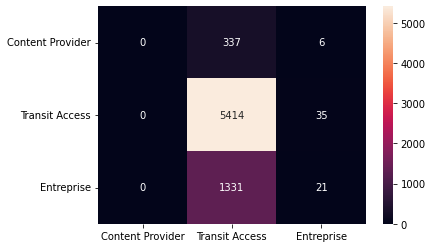

In [ ]:
#ici on pourrait charger le dernier modèle et verifier les perf sur lui (on peut en effet génrer plusieures versions du modèle)
print(checkpoint_callback.best_model_path)
test_acc = evaluate(model, datamodule.g, datamodule.test_nid)
print('Test accuracy:', test_acc)


In [ ]:
#on charge le dernier checkpoint
checkpoint = th.load(checkpoint_callback.best_model_path)
#on affiche quelques caractèristiques du modèle chargé 
print(checkpoint.keys())
print(len(checkpoint["state_dict"]))

Missing logger folder: logs/default


dict_keys(['epoch', 'global_step', 'pytorch-lightning_version', 'state_dict', 'callbacks', 'optimizer_states', 'lr_schedulers', 'hparams_name', 'hyper_parameters'])
15


'logs/default/version_0'

**Possibilité de finetuner un modèle qui est deja entraîné sur un graphe de benchmark et l'appliquer à notre problème **

# Execution de l'entraînement non supervisé 


> La cell suivante ne s'execute pas car la partie non supervisé n'a pas pu être adapté dans les délais du projet



In [ ]:
epochs = 20
batch = 1000
num_layers = 3 
num_hidden = 16
#nombre d'échantillons négatifs pris
num_negs = 10
#proportion d'échantillons négatifs 
neg_share = 0.3
dropout = 0.2
lr = 1e-4
agregator = "mean"
activation = F.relu
logger = TensorBoardLogger("logs_unsup")
datamodule = Data_Unsupervised_Module(num_layers,num_negs,neg_share, batch_size=batch)
model_unsup = SAGE_Unsupervised_Lightning(datamodule.in_feats, num_hidden, datamodule.n_classes,num_layers,activation,dropout,lr,agregator)
# Train
unsupervised_callback = UnsupervisedClassification()
checkpoint_callback = ModelCheckpoint(monitor='val_f1_micro', save_top_k=1)
trainer = Trainer(logger,
                  epochs,
                  val_check_interval=1000,
                  callbacks=[checkpoint_callback, unsupervised_callback],
                  num_sanity_val_steps=0)
trainer.fit(model_unsup, datamodule=datamodule)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=20)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=20)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name     | Type             | Params
----------------------------------------------
0 | module   | SAGE             | 899   
1 | loss_fcn | CrossEntropyLoss | 0     
----------------------------------------------
899       Trainable params
0         Non-trainable params
899       Total params
0.004     Total estimated model params size (MB)
/usr/local/lib/python3.7/dist-packages/dgl/base.py:45: DGLWarning: EdgeDataLoader directly taking a BlockSampler will be deprecated and it will not support feat

AttributeError: ignored